In [10]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

# data prepare

In [2]:
use_cuda = torch.cuda.is_available()

root = './data'
if not os.path.exists(root):
    os.mkdir(root)
    
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

Processing...
Done!


In [9]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

print('==>>> total trainning batch number: {}'.format(len(train_loader)))
print('==>>> total testing batch number: {}'.format(len(test_loader)))

==>>> total trainning batch number: 600
==>>> total testing batch number: 100


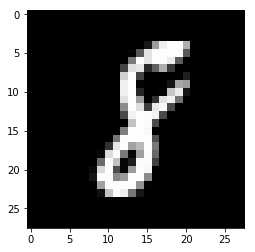

In [34]:
inputs, _ = next(iter(train_loader))
img = inputs[4][0]

import matplotlib.pyplot as plt
plt.imshow(img, cmap='gray', interpolation='nearest')

# MODEL

In [11]:
class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
        
    def forward(self, x):
        x = x.view(-1, 28*28) #flat시키기
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def name(self):
        return "MLP"

    
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def name(self):
        return "LeNet"

# Training

In [61]:
model = MLPNet()

if use_cuda:
    model = model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, 10):
    # trainning
    ave_loss = 0
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        if use_cuda:
            x, target = x.cuda(), target.cuda()
        x, target = Variable(x), Variable(target)
        
        out = model(x)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        if (batch_idx+1) % 100 == 0 or (batch_idx+1) == len(train_loader):
            print('==>>> epoch: {}, batch index: {}, train loss: {:.6f}'.format(
                epoch, batch_idx+1, loss,data))
            
    # testing
    correct_cnt = 0
    total_cnt= 0
    for batch_idx, (x, target) in enumerate(test_loader):
        with torch.no_grad():
            if use_cuda:
                x, target = x.cuda(), target.cuda()
            x, target = Variable(x), Variable(target)
            
            out = model(x)
            loss = criterion(out, target)
            _, pred_label = torch.max(out.data, 1)
            total_cnt = total_cnt + batch_size
            count = torch.sum(pred_label == target.data)
            
            correct_cnt = correct_cnt + count.item()
            if(batch_idx+1) % 100 == 0 or (batch_idx+1) == len(test_loader):
                print('==>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}'.format(
                    epoch, batch_idx+1, loss.data , correct_cnt * 1.0 / total_cnt))

==>>> epoch: 1, batch index: 100, train loss: 0.891320
==>>> epoch: 1, batch index: 200, train loss: 0.446379
==>>> epoch: 1, batch index: 300, train loss: 0.244804
==>>> epoch: 1, batch index: 400, train loss: 0.372875
==>>> epoch: 1, batch index: 500, train loss: 0.355076
==>>> epoch: 1, batch index: 600, train loss: 0.414167
88
==>>> epoch: 1, batch index: 100, test loss: 0.436909, acc: 0.917
==>>> epoch: 2, batch index: 100, train loss: 0.326387
==>>> epoch: 2, batch index: 200, train loss: 0.343088
==>>> epoch: 2, batch index: 300, train loss: 0.222809
==>>> epoch: 2, batch index: 400, train loss: 0.426197
==>>> epoch: 2, batch index: 500, train loss: 0.238889
==>>> epoch: 2, batch index: 600, train loss: 0.089522
94
==>>> epoch: 2, batch index: 100, test loss: 0.304139, acc: 0.943
==>>> epoch: 3, batch index: 100, train loss: 0.139597
==>>> epoch: 3, batch index: 200, train loss: 0.183021
==>>> epoch: 3, batch index: 300, train loss: 0.115531
==>>> epoch: 3, batch index: 400, tra